# PRÁCTICA FINAL: MODELOS

**Machine Learning: Modelos Supervisados**

*Autores: Marta Delgado, Susana Jodra, Marta Onieva, Loreto Torres*

#### Objetivo

En este apartado generamos dos modelos que nos ayuden a predecir los fallecimientos y además, determinar si necesitarán tratamiento médico, para ello utilizamos los modelos de **Regresión Logística** y **XGBoost**, aunque hay más modelos que hemos estudiado en clase:
1. Regresión Logística
2. K-NN
3. Arbol de decisión simple
4. Bagging Classifier
5. Random Forest
6. Gradient Boost
7. XGBoost

Y posteriormente los evaluamos en función de las métricas de:
- Accuracy
- Precision
- Recall
- Confusion Matrix
- F-score
- Curva ROC
- Area bajo la curva

Seleccionaremos el mejor modelo y analizaremos la importancia del resto de variables para ese modelo según el peso, ganancia y cover.

Tras este análisis responderemos a la pregunta planteada sobre el tratamiento médico y haremos una conclusión.

### Dado un accidente, ¿se puede generar un modelo que prediga si habrá fallecimientos o no? ¿Si se va a necesitar tratamiento médico o no? Las aseguradoras tienen que inmovilizar capital para pagar estas casuísticas.

In [1]:
# Importamos las librerías a utilizar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import seaborn as sb
import plotly.graph_objects as go
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import KernelPCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, roc_auc_score

warnings.filterwarnings('ignore')

In [132]:
db = pd.read_csv("NCDB_1999_to_2014.csv")

In [133]:
#diferenciamos numéricas de categóricas
numerical_var = (db.dtypes[db.dtypes!='object'].index.to_list())
categorical_var = (db.dtypes[db.dtypes=='object'].index.to_list())

print('Variables numéricas ', numerical_var)
print('Variables categóricas: ', categorical_var)

Variables numéricas  ['C_YEAR', 'C_SEV']
Variables categóricas:  ['C_MNTH', 'C_WDAY', 'C_HOUR', 'C_VEHS', 'C_CONF', 'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF', 'V_ID', 'V_TYPE', 'V_YEAR', 'P_ID', 'P_SEX', 'P_AGE', 'P_PSN', 'P_ISEV', 'P_SAFE', 'P_USER']


In [134]:
# Valores sin información: cambiar
cambio_Q = ['Q', 'QQ', 'QQQQ']
cambio_N = ['N', 'NN', 'NNNN']
cambio_U = ['U', 'UU', 'UUUU']
cambio_X = ['X', 'XX', 'XXXX']

In [135]:
db[categorical_var] = db[categorical_var].replace(cambio_Q, 0)
db[categorical_var] = db[categorical_var].replace(cambio_N, 0)
db[categorical_var] = db[categorical_var].replace(cambio_U, 0)
db[categorical_var] = db[categorical_var].replace(cambio_X, 0)

#### Valores nulos

In [136]:
db.isnull().sum()

C_YEAR    0
C_MNTH    0
C_WDAY    0
C_HOUR    0
C_SEV     0
C_VEHS    3
C_CONF    0
C_RCFG    0
C_WTHR    0
C_RSUR    0
C_RALN    0
C_TRAF    0
V_ID      0
V_TYPE    0
V_YEAR    0
P_ID      0
P_SEX     0
P_AGE     0
P_PSN     0
P_ISEV    0
P_SAFE    0
P_USER    0
dtype: int64

Al tratarse de solo 3 valores de la columna de 'C_VEHS', la cual indica el número de vehículos implicados en el accidente, eliminamos los valores NA:

In [137]:
db=db.dropna()

Moficamos la variables de 'P_SEX' para que sea numérica como el resto de variables:

In [138]:
db.P_SEX.replace({'M':0,'F':1},inplace=True)

In [139]:
df_model = db.copy()

In [140]:
numerical = ['C_YEAR', 'C_SEV', 'C_MNTH', 'C_WDAY','C_HOUR', 'C_VEHS', 'C_CONF','C_RCFG','C_WTHR','C_RSUR','C_RALN',
        'C_TRAF','V_ID','V_TYPE', 'V_YEAR','P_ID','P_AGE','P_PSN','P_ISEV','P_SAFE','P_USER','P_SEX']

df_model = df_model[numerical].astype(int)

### Variable Objetivo: C_SEV

#### Distribución de la variable objetivo

In [141]:
df_model['C_SEV'].value_counts()

2    5761769
1      98633
Name: C_SEV, dtype: int64

2    98.316958
1     1.683042
Name: C_SEV, dtype: float64


Text(0, 0.5, 'Frecuencia')

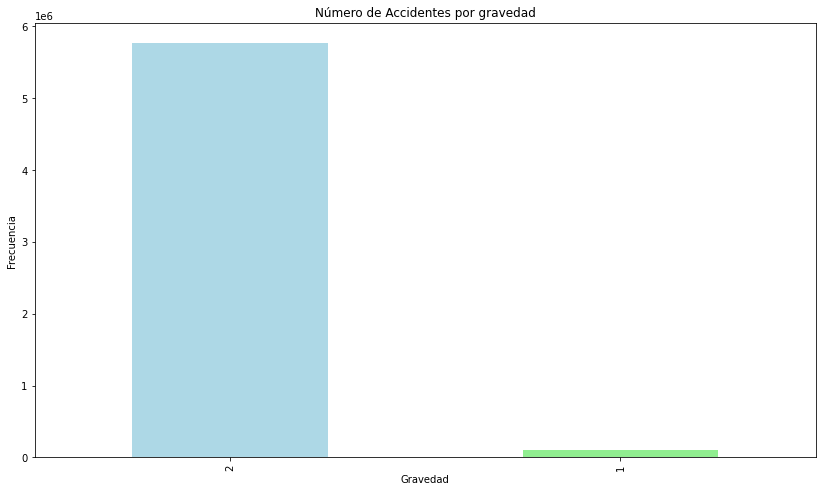

In [142]:
print(df_model['C_SEV'].value_counts()/sum(df_model['C_SEV'].value_counts())*100)
ax = df_model['C_SEV'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Número de Accidentes por gravedad", color=["lightblue","lightgreen"])
ax.set_xlabel("Gravedad")
ax.set_ylabel("Frecuencia")

Antes de comenzar con el entrenamiento y validación de los modelos, observamos como se distribuye la variable objetivo. C_SEV nos indica la gravedad de la colisión, de forma que los accidentes con un valor 1 en esta columna son aquellos en los cuales al menos se ha producido una muerte, mientras que los accidentes que toman el valor 2 no son mortales. Observamos que la gran mayoría (98,32%) de accidentes no han sido mortales frente al **1,68% de accidentes mortales**.

Esta distribución desproporcionada nos indica la necesidad de dividir los conjuntos de entrenamiento y validación de forma proporcionada, ya que si no se podría dar que la mayoría de accidentes mortales se encuentren en un subconjunto.

#### Correlaciones: variable objetivo (C_SEV) con resto de variables

In [143]:
df_model[df_model.columns[1:]].corr()['C_SEV'][:].sort_values(ascending=False)

C_SEV     1.000000
P_SEX     0.027959
C_RCFG    0.027682
C_CONF    0.020953
C_HOUR    0.018129
V_YEAR    0.008976
C_MNTH   -0.005877
C_RSUR   -0.007126
P_SAFE   -0.009124
C_VEHS   -0.017820
C_WDAY   -0.018195
C_WTHR   -0.018498
P_USER   -0.018692
P_AGE    -0.019447
V_ID     -0.019447
P_PSN    -0.027771
V_TYPE   -0.027969
P_ID     -0.031769
C_RALN   -0.059322
C_TRAF   -0.060905
P_ISEV   -0.134780
Name: C_SEV, dtype: float64

Como podemos observar ninguna variable está correlacionada con la variable objetivo ni positivamente ni negativamente, son independientes.

#### División conjuntos de entrenamiento y validación (train y test)

In [144]:
objetivo = ['C_SEV']

In [145]:
X = df_model.drop(objetivo,axis=1)
Y = df_model[objetivo]

In [146]:
# Division del dataset en entrenamiento y test
# proporcion 30 y 70
# utilizamos stratify para que los subconjuntos mantengan la proporción de las clases

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=0)

In [147]:
# conjunto de entrenamiento (TRAIN)
print(x_train.shape)
# 4102281 filas

print(y_train['C_SEV'].value_counts()/sum(y_train['C_SEV'].value_counts())*100)
y_train.value_counts()

(4102281, 21)
2    98.316229
1     1.683771
Name: C_SEV, dtype: float64


C_SEV
2        4033208
1          69073
dtype: int64

In [148]:
# conjunto de validación (TEST)
x_test.shape
# 1758121 filas

print(y_test['C_SEV'].value_counts()/sum(y_test['C_SEV'].value_counts())*100)
y_test.value_counts()

2    98.31866
1     1.68134
Name: C_SEV, dtype: float64


C_SEV
2        1728561
1          29560
dtype: int64

Los conjuntos están desbalanceados dada la desproporcionada distribución de la variable objetivo en la base de datos original. Se mantiene la distribución de 1,68% de accidentes mortales frente a 98,32% de accidentes no mortales.

## Modelos

### **REGRESIÓN LOGÍSTICA**

In [149]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()

**CONJUNTO DE ENTRENAMIENTO**

In [150]:
logit.fit(x_train, y_train)

LogisticRegression()

In [210]:
# ACCURACY
accuracy_score(y_train, logit.predict(x_train))

# 0.983162294343074

0.983162294343074

La métrica de **exactitud** nos indica que el modelo es muy bueno, sin embargo hay que tener en cuenta que las clases están desbalanceadas, ya que predominan los casos en los que los accidentes no son mortales, y esta métrica es engañosa cuando esto sucede porque nos hace creer que el modelo es mejor de lo que en realidad es. Por eso, calculamos el resto de métricas para comparar.

In [152]:
# PRECISION
precision_score(y_train, logit.predict(x_train))

# 0.41964285714285715

0.41964285714285715

De acuerdo a la métrica de **precisión**, obtenemos que el modelo se equivocará el 58% de las veces que prediga que un accidente será mortal y solo acertará el 41,96% de las veces.

In [153]:
# RECALL
recall_score(y_train, logit.predict(x_train))

# 0.0013608790699694527

0.0013608790699694527

La métrica de **exhaustividad** (RECALL) nos informa de la cantidad de fallecimientos que el modelo de machine learning entrenado es capaz de identificar. Obtenemos que el modelo es solo capaz de identificar aproximandamente el 0,14% de los accidentes que son mortales.

In [154]:
# CONFUSION MATRIX
cm = confusion_matrix(y_train, logit.predict(x_train))

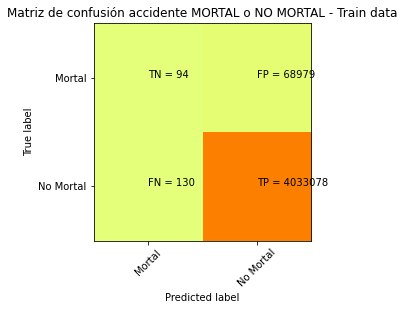

In [155]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
class1 = ['Mortal','No Mortal']
plt.title('Matriz de confusión accidente MORTAL o NO MORTAL - Train data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(class1))
plt.xticks(tick_marks, class1, rotation=45)
plt.yticks(tick_marks, class1)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

Según la **matriz de confusión** que obtenemos del modelo entrenado concluimos que el modelo si que sirve para predecir los accidentes no mortales (Verdaderos Positivos - True Positive: el modelo predice que no son mortales y verdaderamente no son mortales). Pero, el modelo no sirve para predecir los mortales ya que la mayoría de accidentes mortales el modelo predice que no son mortales (los considera Falsos Positivos).

In [156]:
# F1 SCORE
f1_score(y_train, logit.predict(x_train))

# 0.0027129601570053535

0.0027129601570053535

El **score F1** combina las métricas de precisión y recall calculadas anteriormente en una sola medida, dando a ambas el mismo peso.

In [157]:
# AREA BAJO LA CURVA
roc_auc_score(y_train, logit.predict(x_train))

# 0.5006643233317043
# el modelo es muy malo

0.5006643233317043

El valor que obtenemos de **área bajo la curva** nos indica que el modelo no predice correctamente, hace predicciones aleatorias.

Una vez entrenado el modelo procedemos a validar los resultados entrenados para comprobar si obtenemos las mismas conclusiones:

**CONJUNTO TEST**

In [158]:
logit.fit(x_test, y_test)

LogisticRegression()

In [211]:
# ACCURACY
accuracy_score(y_test, logit.predict(x_test))

# 0.9831865952343439

0.9831865952343439

Como ocurría en el conjunto de entrenamiento, la métrica de **exactitud (Accuracy)** nos indica que el modelo es muy bueno, aunque la realidad es lo contrario.

In [160]:
# PRECISION
precision_score(y_test, logit.predict(x_test))
# 0.0

0.0

Según la métrica de **precisión**, el modelo no acierta ni un solo accidente mortal.

In [161]:
# RECALL
recall_score(y_test, logit.predict(x_test))
# 0.0

0.0

De acuerdo a la métrica de **exhaustividad (o recall)** el modelo no es capaz de identificar qué accidentes son mortales ya que los clasifica todos como no mortales, como observaremos a continuación en la matriz de confusión

Dado que ambas métricas de Recall y Precision son 0 **no es necesario calcular el valor de F1 score ya que también será 0**.

In [162]:
# CONFUSION MATRIX
cm = confusion_matrix(y_test, logit.predict(x_test))
cm

array([[      0,   29560],
       [      0, 1728561]], dtype=int64)

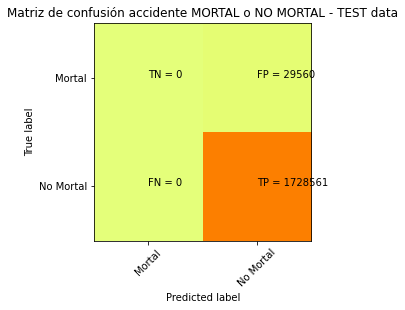

In [163]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
class1 = ['Mortal','No Mortal']
plt.title('Matriz de confusión accidente MORTAL o NO MORTAL - TEST data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(class1))
plt.xticks(tick_marks, class1, rotation=45)
plt.yticks(tick_marks, class1)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

Tras calcular la **matriz de confusión** obtenemos que el modelo predice todos los accidentes como no mortales por ello obtenemos que le modelo predice correctamente los Verdaderos Positivos (True Positive: aquellos que el modelo predice como no mortales y verderamente son no mortales), mientres que el modelo es incapaz de predecir los accidentes mortales porque los clasifica como Falsos Positivos (False Positive: aquellos accidentes que el modelo predice como no mortales y en realidad son mortales).

In [73]:
# AREA BAJO LA CURVA
roc_auc_score(y_test, logit.predict(x_test))
# 0.5
# el modelo es nulo

0.5

El modelo no sirve para predecir la mortalidad de los accidentes, ya que predice los resultados aleatoriamente según el **score del area bajo la curva**.

### **XGBoost**

In [181]:
model = XGBClassifier(subsample = 0.7, max_depth = 4)

In [182]:
model.fit(x_train, y_train, eval_metric='rmse')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

**CONJUNTO de ENTRENAMIENTO**

In [202]:
# ACCURACY
accuracy_score(y_train, model.predict(x_train))

# 0.9902473770080596

0.9902473770080596

In [204]:
# PRECISION
precision_score(y_train, model.predict(x_train))
# 0.9881428235531222

0.9881428235531222

In [205]:
# RECALL
recall_score(y_train, model.predict(x_train))
# 0.4258972391527804

0.4258972391527804

In [206]:
#F1 SCORE
f1_score(y_train, model.predict(x_train))
# 0.5952409857957994

0.5952409857957994

In [207]:
# AREA BAJO LA CURVA
roc_auc_score(y_train, model.predict(x_train))
# 0.7129048578859443

0.7129048578859443

In [208]:
# CONFUSION MATRIX
cm = confusion_matrix(y_train, model.predict(x_train))
cm

array([[  29418,   39655],
       [    353, 4032855]], dtype=int64)

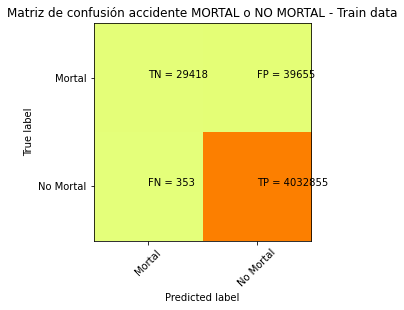

In [209]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
class1 = ['Mortal','No Mortal']
plt.title('Matriz de confusión accidente MORTAL o NO MORTAL - Train data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(class1))
plt.xticks(tick_marks, class1, rotation=45)
plt.yticks(tick_marks, class1)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

Mediante la **matriz de correlación** se observa que mediante este modelo se predice mejor los True Negative (Verdaderos Negativos: aquellos accidentes que el modelo predice que son mortales y que en realidad son mortales) aunque el número de False Negative (Falso Negativos: aquellos accidentes que el modelo predice que no son mortales y en realidad son mortales). El objetivo de la predicción de los modelos es minimizar el total de Falsos Positivos y Falsos Negativos, que es lo mismo que maximizar los Verdaderos Negativos y Verdaderos Positivos.

Todas las métricas que obtenemos para el conjunto de entrenamiento del modelo de XGBoost son mejores que las del modelo anterior. Ahora procedemos a comprobar si ocurre lo mismo con el conjunto de validación.

**CONJUNTO TEST**

In [184]:
# ACCURACY
accuracy_score(y_test, model.predict(x_test))

# 0.9902663127281911

0.9902663127281911

In [198]:
# PRECISION
precision_score(y_test, model.predict(x_test))
# 0.9867813844348846

0.9867813844348846

In [199]:
# RECALL
recall_score(y_test, model.predict(x_test))
# 0.42679296346414075

0.42679296346414075

In [200]:
#F1 SCORE
f1_score(y_test, model.predict(x_test))
# 0.5958672806706814

0.5958672806706814

In [201]:
# AREA BAJO LA CURVA
roc_auc_score(y_test, model.predict(x_test))
# 0.7133475971396261

0.7133475971396261

Confirmamos con las métricas que el modelo es un poco mejor que el anterior aunque la **exhaustividad (o recall)** es limitada (el modelo es capaz de identificar solo el 42,68% de los accidentes mortales) lo que hace que el **score F1** disminuya en comparación con la **precisión** de casi el 99%. El **área bajo la curva** se acerca más a 1 que el anterior modelo, lo que indica que este modelo es más preciso.

In [194]:
# CONFUSION MATRIX
cm = confusion_matrix(y_test, model.predict(x_test))
cm

array([[  12616,   16944],
       [    169, 1728392]], dtype=int64)

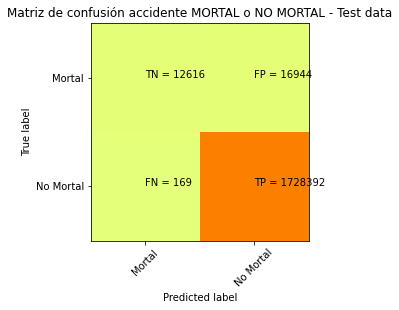

In [195]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
class1 = ['Mortal','No Mortal']
plt.title('Matriz de confusión accidente MORTAL o NO MORTAL - Test data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(class1))
plt.xticks(tick_marks, class1, rotation=45)
plt.yticks(tick_marks, class1)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

Al igual que ocurre con la matriz de confusión del conjunto de entrenamiento, en este caso se reduce el número de Falsos Positivos, aunque el modelo sigue sin ser capaz de identificar al menos el 50% de los accidentes mortales (como hemos visto antes con la precisión del 42%). Se reduce el número de Verdaderos Positivos respecto al modelo anterior por 169, que se compensa con la identificación de los Verdaderos Negativos. Es por ello, que se puede decir que el modelo de XGboost es más preciso que el modelo de Regresión Logística calculado previamente.

# Interpretación

Dado que el modelo que mejor predice es el XGBoost, analizaremos la **importancia de las variables** de la base de datos en el modelo y la variable objetivo **según el peso, cover y ganancia**:

**Importancia de las variables según el PESO:**

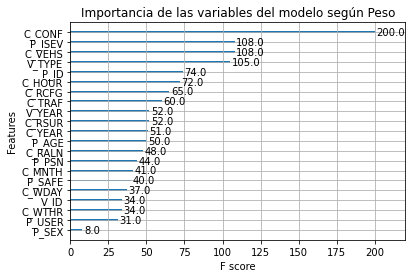

In [220]:
xgb.plot_importance(model)
plt.title('Importancia de las variables del modelo según Peso')
plt.show()

El peso muestra el número de veces que la característica se utiliza para dividir los datos. Este tipo de importancia de la característica puede favorecer las características numéricas y de alta cardinalidad. Se usa por default.

En este caso la variable más importante es *'C_CONF'* que corresponde a la configuración del accidente (proporciona información sobre el movimiento de los vehículos y la dirección). También son importantes en menor medida pero por valores muy similares: *'P_ISEV'* (tratamiento médico requerido), *'C_VEHS'* (número de vehículos implicados en el accidente) y *'V_TYPE'* (tipo de vehiculo).

La variable menos importante respecto al peso es *'P_SEX'* (genero), seguido por más de 20 puntos *'P_USER'* (tipo de usuario de la carretera), *'C_WTHR'* (Condiciones meteorológicas) y *'V_ID'* (Número de secuencia del vehículo).


**Importancia de las variables según COVER (cobertura):**

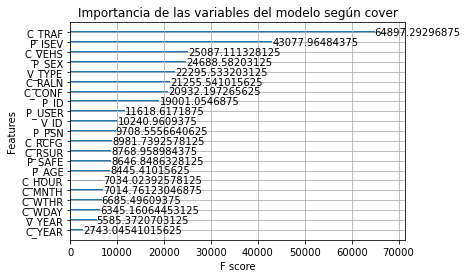

In [221]:
# Importancia por cover
xgb.plot_importance(model, importance_type="cover")
plt.title('Importancia de las variables del modelo según cover')
plt.show()

La métrica Cover (cobertura) significa el número relativo de observaciones relacionadas con esta característica. 

La variable más importante es *'C_TRAF'* (control del tráfico), seguido por mucha distancia de *'P_ISEV'* (tratamiento médico requerido) y *'C_VEHS'* (número de vehículos implicados en el accidente).

Las variables menos importantes son las relativas a fechas como el año del accidente, *'C_YEAR'*, el año del vehículo, *'V_YEAR'*, el día de la semana del accidente, *'C_WDAY'*.

**Importancia de las variables según GANANCIA:**

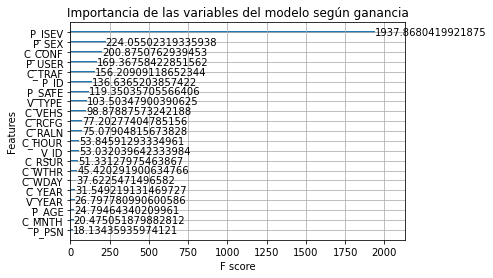

In [222]:
# Importancia por ganancia
xgb.plot_importance(model, importance_type="gain")
plt.title('Importancia de las variables del modelo según ganancia')
plt.show()

La ganancia implica la contribución relativa de la característica correspondiente al modelo, calculada tomando la contribución de cada característica para cada árbol del modelo. Un valor más alto de esta métrica en comparación con otra característica implica que es más importante para generar una predicción. Por ello, la ganancia es el atributo más relevante para interpretar la importancia relativa de cada característica.

La variable más importante con mucha distancia respecto al resto es *'P_ISEV'* (tratamiento médico requerido).

Las variables menos importantes son *'P_PSN'* (posición), *'C_MNTH'* (mes del accidente), *'P_AGE'* (edad) y *'V_YEAR'* (año del modelo del vehículo.

#### Estudio de la distribución de P_ISEV (tratamiento médico)

2    52.443996
1    40.529762
0     6.337654
3     0.688588
Name: P_ISEV, dtype: float64


Text(0, 0.5, 'Frecuencia')

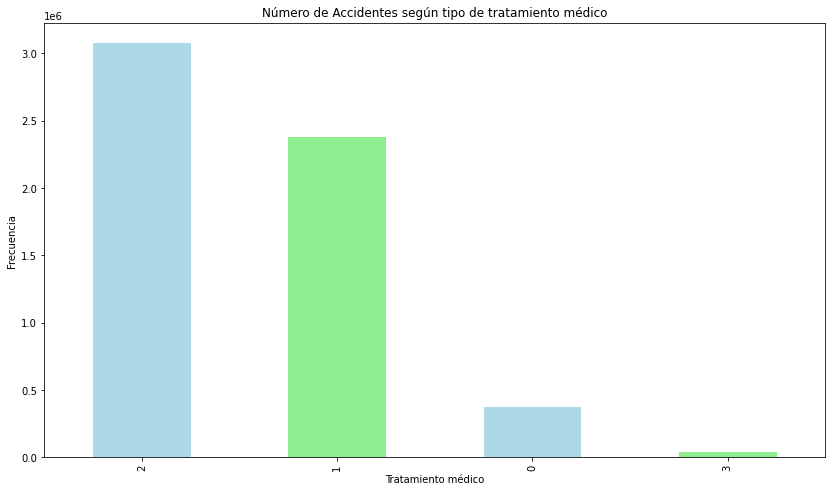

In [224]:
print(df_model['P_ISEV'].value_counts()/sum(df_model['P_ISEV'].value_counts())*100)
ax = df_model['P_ISEV'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Número de Accidentes según tipo de tratamiento médico", color=["lightblue","lightgreen"])
ax.set_xlabel("Tratamiento médico")
ax.set_ylabel("Frecuencia")

P_ISEV: tratamiento médico requerido
- 0: valores especiales modificados (N, U, X)    
- 1: ninguna lesión
- 2: lesión
- 3: mortal

# Conclusiones

**Dado un accidente, ¿se puede generar un modelo que prediga si habrá fallecimientos o no? ¿Si se va a necesitar tratamiento médico o no? Las aseguradoras tienen que inmovilizar capital para pagar estas casuísticas.**

- Tras haber entrenado los modelos de Regresión Logística y XGBoost, hemos determinado que el modelo XGBoost predice mejor la mortalidad de los accidentes basándonos en las métricas de precisión, exactitud, recall, matriz de confusión y área bajo la curva.
- Una vez seleccionado el modelo XGBoost, hemos determinado la importancia de las variables según los tipos de peso, ganancia y cover. Todos tienen en común que la variable más importante es *'P_ISEV'* que informa sobre el tratamiento médico.
- Según el breve estudio de la distribución de la variable del tratamiento médico, más de la mitad necesitan atención médica, solo fallecen en el acto el 0,69%. Las aseguradoras deberían inmovilizar provisiones para atender al tratamiento médico que suponen los accidentes, ya que solo en el 40% de las ocasiones no hay lesiones.